# Defining Necessary function for the project


In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
from sklearn import metrics
from sklearn.utils.validation import validate_data
import matplotlib.pyplot as plt
import os
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.debugging.set_log_device_placement(True)  # Logs which device is used
    except RuntimeError as e:
        print(e)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


This code is about building a Convolutional Neural Networks for recognizing handwritten digit in 10 different languages.

the dataset include the following languages:
'Arabic', 'Bangla', 'Devanagari', 'English', 'Farsi', 'Kannada', 'Swedish', 'Telugu', 'Tibetan', 'Urdu'

In [3]:
#first we load the dataset
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/Colab Notebooks/MNIST-MIX-all.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset_folder')

In [4]:
# calculate two performance metrics for classification tasks: F1-score and Balanced Accuracy Score
def evaluate(predicted_outcome, expected_outcome):
    from sklearn import metrics
    f1_score = metrics.f1_score(expected_outcome, predicted_outcome, average='weighted')
    balanced_accuracy_score = metrics.balanced_accuracy_score(expected_outcome, predicted_outcome)
    return f1_score, balanced_accuracy_score

load_dataset_with_processing function, splite the dataset into train, validation and test sets

In [5]:
def load_dataset_with_processing(input_train_test_fn, num_classes=10):
    # Load data from file
    data = np.load(input_train_test_fn)
    X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

    # Split validation set
    X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

    # Normalize datasets
    X_train = X_train.astype("float32") / 255.0
    X_vali = X_vali.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0

    # Apply SMOTE to balance training data
    smote = SMOTE(random_state=42)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten for SMOTE
    X_train_flat, y_train = smote.fit_resample(X_train_flat, y_train)
    X_train = X_train_flat.reshape(X_train_flat.shape[0], 28, 28, 1)  # Reshape back

    # Reshape validation and test data to the same format
    X_vali = X_vali.reshape(X_vali.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

    # Convert labels to one-hot encoding
    y_train = to_categorical(y_train, num_classes)
    y_vali = to_categorical(y_vali, num_classes)
    y_test = to_categorical(y_test, num_classes)

    # Return the same structure as the original function
    return X_train, y_train, X_vali, y_vali, X_test, y_test


myGenerator function divid the training set into batches Generates a random permutation of indices and ensures the dataset is shuffled at the start of each epoch.

In [6]:
def myGenerator(X_train, y_train, batch_size):
    total_size = X_train.shape[0]

    while True:
        # Shuffle indices
        permutation = list(np.random.permutation(total_size))
        for i in range(0, total_size, batch_size):
            # Handle last batch
            index = permutation[i : min(i + batch_size, total_size)]
            X_batch = X_train[index]
            y_batch = y_train[index]

            # Yield the batch
            yield X_batch, y_batch




build a Convolutional Nural Network consist of input layer, 3 hidden layers, and output layer

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_CNN(input_shape, num_classes):
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(64, (3, 3), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Second convolutional layer
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output of the convolutional layers
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(256))
    model.add(Activation("relu"))

    # Dropout to prevent overfitting (especially if using more data)
    model.add(Dropout(0.5))

    # Output layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation="softmax"))

    model.summary()

    return model




train_fn train the created CNN and save the model that gives the achieve the best val_accuracy during the training


In [8]:
def train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs):

    if os.path.exists(checkpoint_dir) is False:
        os.makedirs(checkpoint_dir)

    model = build_CNN(input_shape, num_classes)

    # Callbacks
    checkpoint = ModelCheckpoint(checkpoint_dir + 'best1.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights=True)

    # Compile Keras Model
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    # Data Generator , pass class_weights to the generator
    datagen = myGenerator(X_train, y_train, batch_size)

    # Train the Model, remove class_weight argument
    history = model.fit(datagen,
                        steps_per_epoch=len(X_train) // batch_size,
                        epochs=epochs,
                        callbacks=[checkpoint, es],
                        verbose=2,
                        validation_data=(X_vali, y_vali))

    # Save the entire model (architecture + weights + optimizer state)
    model.save(checkpoint_dir + 'full_model1.keras')

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()

    return model

test the trained model on the test set

In [9]:
def test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights):
    model = build_CNN(input_shape, num_classes)

    # Compile Keras Model
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    # load weights
    model.load_weights(pretrained_weights)

    score = model.evaluate(X_test, y_test, verbose=0)

    testPredict = model.predict(X_test)
    y_test_tmp = np.argmax(y_test, axis=1)
    y_pred_tmp = np.argmax(testPredict, axis=1)
    f1_score, balanced_accuracy_score = evaluate(y_pred_tmp, y_test_tmp)

    return score[1], f1_score, balanced_accuracy_score  # return accuracies

# Training the model.

In [10]:
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.001 , clipnorm=1.0)
metrics = ['accuracy']
batch_size = 256
epochs = 200

checkpoint_dir = './MNIST_MIX_Trained_Model/'
input_train_test_fn = './dataset_folder/MNIST_MIX_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          25,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,706,084 (6.51 MB)

 Trainable params: 1,706,084 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.98308, saving model to ./MNIST_MIX_Trained_Model/best1.keras
7500/7500 - 67s - 9ms/step - accuracy: 0.9540 - loss: 0.1610 - val_accuracy: 0.9831 - val_loss: 0.0618
Epoch 2/200

Epoch 2: val_accuracy improved from 0.98308 to 0.98684, saving model to ./MNIST_MIX_Trained_Model/best1.keras
7500/7500 - 54s - 7ms/step - accuracy: 0.9892 - loss: 0.0350 - val_accuracy: 0.9868 - val_loss: 0.0532
Epoch 3/200

Epoch 3: val_accuracy improved from 0.98684 to 0.98792, saving model to ./MNIST_MIX_Trained_Model/best1.keras
7500/7500 - 55s - 7ms/step - accuracy: 0.9929 - loss: 0.0228 - val_accuracy: 0.9879 - val_loss: 0.0509
Epoch 4/200

Epoch 4: val_accuracy improved from 0.98792 to 0.98882, saving model to ./MNIST_MIX_Trained_Model/best1.keras
7500/7500 - 54s - 7ms/step - accuracy: 0.9946 - loss: 0.0174 - val_accuracy: 0.9888 - val_loss: 0.0497
Epoch 5/200

Epoch 5: val_accuracy did not improve from 0.98882
7500/7500 - 54s - 7ms/step - accura

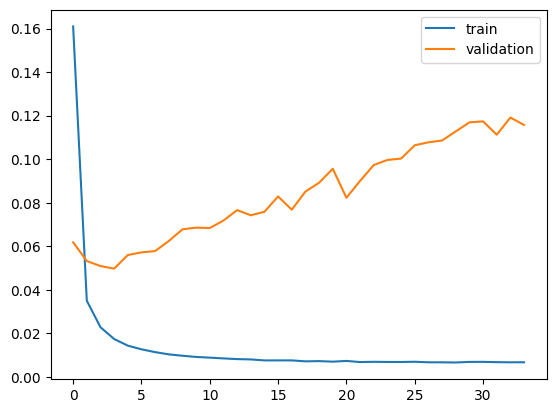

<Sequential name=sequential, built=True>

In [11]:
train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [12]:
pretrained_weights = './MNIST_MIX_Trained_Model/best1.keras'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          25,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,706,084 (6.51 MB)

 Trainable params: 1,706,084 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

3349/3349 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Accuracy:  0.9583232402801514
Weighted F1:  0.9581367717746638
Balanced Accuracy:  0.9502687161807242


In [13]:
import numpy as np
from collections import Counter # Import the Counter class

# Convert one-hot encoded labels back to raw class labels
raw_labels = np.argmax(y_vali, axis=1)

# Count the samples per class
class_counts_after_encoding = Counter(raw_labels)
class_counts_after_encoding = sorted(class_counts_after_encoding.items())
print("Class distribution (from one-hot):", class_counts_after_encoding)

Class distribution (from one-hot): [(0, 1248), (1, 1248), (2, 1248), (3, 1248), (4, 1248), (5, 1248), (6, 1248), (7, 1248), (8, 1248), (9, 1248), (10, 799), (11, 802), (12, 797), (13, 803), (14, 802), (15, 800), (16, 799), (17, 795), (18, 800), (19, 800), (20, 48), (21, 48), (22, 48), (23, 48), (24, 48), (25, 48), (26, 48), (27, 48), (28, 48), (29, 48), (30, 4800), (31, 4800), (32, 4800), (33, 4800), (34, 4800), (35, 4800), (36, 4800), (37, 4800), (38, 4800), (39, 4800), (40, 1200), (41, 1200), (42, 1200), (43, 1200), (44, 1200), (45, 1200), (46, 1200), (47, 1200), (48, 1200), (49, 1200), (50, 1200), (51, 1200), (52, 1200), (53, 1200), (54, 1200), (55, 1200), (56, 1200), (57, 1200), (58, 1200), (59, 1200), (60, 132), (61, 132), (62, 132), (63, 132), (64, 132), (65, 132), (66, 132), (67, 132), (68, 132), (69, 132), (70, 48), (71, 48), (72, 48), (73, 48), (74, 48), (75, 48), (76, 48), (77, 48), (78, 48), (79, 48), (80, 319), (81, 341), (82, 299), (83, 291), (84, 315), (85, 216), (86, 259

# test the trained model


the following list, map each class in the dataset to its corresponding digit and langauge


In [14]:
digit_language_mapping = {
    0: '0 (Arabic)', 1: '1 (Arabic)', 2: '2 (Arabic)', 3: '3 (Arabic)', 4: '4 (Arabic)', 5: '5 (Arabic)', 6: '6 (Arabic)', 7: '7 (Arabic)', 8: '8 (Arabic)', 9: '9 (Arabic)',
    10: '0 (Bangla)', 11: '1 (Bangla)', 12: '2 (Bangla)', 13: '3 (Bangla)', 14: '4 (Bangla)', 15: '5 (Bangla)', 16: '6 (Bangla)', 17: '7 (Bangla)', 18: '8 (Bangla)', 19: '9 (Bangla)',
    20: '0 (Devanagari)', 21: '1 (Devanagari)', 22: '2 (Devanagari)', 23: '3 (Devanagari)', 24: '4 (Devanagari)', 25: '5 (Devanagari)', 26: '6 (Devanagari)', 27: '7 (Devanagari)', 28: '8 (Devanagari)', 29: '9 (Devanagari)',
    30: '0 (English)', 31: '1 (English)', 32: '2 (English)', 33: '3 (English)', 34: '4 (English)', 35: '5 (English)', 36: '6 (English)', 37: '7 (English)', 38: '8 (English)', 39: '9 (English)',
    40: '0 (Farsi)', 41: '1 (Farsi)', 42: '2 (Farsi)', 43: '3 (Farsi)', 44: '4 (Farsi)', 45: '5 (Farsi)', 46: '6 (Farsi)', 47: '7 (Farsi)', 48: '8 (Farsi)', 49: '9 (Farsi)',
    50: '0 (Kannada)', 51: '1 (Kannada)', 52: '2 (Kannada)', 53: '3 (Kannada)', 54: '4 (Kannada)', 55: '5 (Kannada)', 56: '6 (Kannada)', 57: '7 (Kannada)', 58: '8 (Kannada)', 59: '9 (Kannada)',
    60: '0 (Swedish)', 61: '1 (Swedish)', 62: '2 (Swedish)', 63: '3 (Swedish)', 64: '4 (Swedish)', 65: '5 (Swedish)', 66: '6 (Swedish)', 67: '7 (Swedish)', 68: '8 (Swedish)', 69: '9 (Swedish)',
    70: '0 (Telugu)', 71: '1 (Telugu)', 72: '2 (Telugu)', 73: '3 (Telugu)', 74: '4 (Telugu)', 75: '5 (Telugu)', 76: '6 (Telugu)', 77: '7 (Telugu)', 78: '8 (Telugu)', 79: '9 (Telugu)',
    80: '0 (Tibetan)', 81: '1 (Tibetan)', 82: '2 (Tibetan)', 83: '3 (Tibetan)', 84: '4 (Tibetan)', 85: '5 (Tibetan)', 86: '6 (Tibetan)', 87: '7 (Tibetan)', 88: '8 (Tibetan)', 89: '9 (Tibetan)',
    90: '0 (Urdu)', 91: '1 (Urdu)', 92: '2 (Urdu)', 93: '3 (Urdu)', 94: '4 (Urdu)', 95: '5 (Urdu)', 96: '6 (Urdu)', 97: '7 (Urdu)', 98: '8 (Urdu)', 99: '9 (Urdu)'
}

load the trained model

In [15]:
from tensorflow.keras.models import load_model

model = load_model('./MNIST_MIX_Trained_Model/full_model1.keras')


Predict function used for testing the trained model, we apply it here on X_test set and print out the result of 10 sampels  

3349/3349 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Probabilities for sample 82445:
Class 0 (0 (Arabic)): 0.000000
Class 1 (1 (Arabic)): 0.000000
Class 2 (2 (Arabic)): 0.000000
Class 3 (3 (Arabic)): 0.000000
Class 4 (4 (Arabic)): 0.000000
Class 5 (5 (Arabic)): 0.000000
Class 6 (6 (Arabic)): 0.000000
Class 7 (7 (Arabic)): 0.000000
Class 8 (8 (Arabic)): 0.000000
Class 9 (9 (Arabic)): 0.000000
Class 10 (0 (Bangla)): 0.000000
Class 11 (1 (Bangla)): 0.000000
Class 12 (2 (Bangla)): 0.000000
Class 13 (3 (Bangla)): 0.000000
Class 14 (4 (Bangla)): 0.000000
Class 15 (5 (Bangla)): 0.000000
Class 16 (6 (Bangla)): 0.000000
Class 17 (7 (Bangla)): 0.000000
Class 18 (8 (Bangla)): 0.000000
Class 19 (9 (Bangla)): 0.000000
Class 20 (0 (Devanagari)): 0.000000
Class 21 (1 (Devanagari)): 0.000000
Class 22 (2 (Devanagari)): 0.000000
Class 23 (3 (Devanagari)): 0.000000
Class 24 (4 (Devanagari)): 0.000000
Class 25 (5 (Devanagari)): 0.000000
Class 26 (6 (Devanagari)): 0.000000
Class 27 (7 (Devanagari)): 0.000000
Class 2

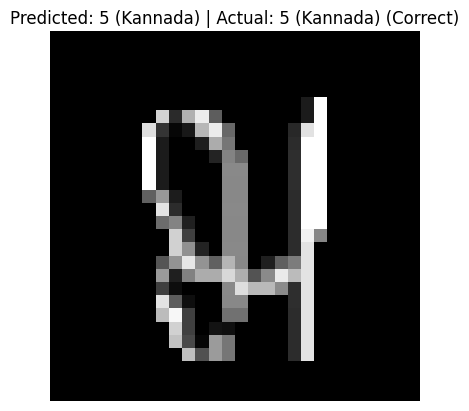

Probabilities for sample 39421:
Class 0 (0 (Arabic)): 0.000000
Class 1 (1 (Arabic)): 0.000000
Class 2 (2 (Arabic)): 0.000000
Class 3 (3 (Arabic)): 0.000000
Class 4 (4 (Arabic)): 0.000000
Class 5 (5 (Arabic)): 0.000000
Class 6 (6 (Arabic)): 0.000000
Class 7 (7 (Arabic)): 0.000000
Class 8 (8 (Arabic)): 0.000000
Class 9 (9 (Arabic)): 0.000000
Class 10 (0 (Bangla)): 0.000000
Class 11 (1 (Bangla)): 0.000000
Class 12 (2 (Bangla)): 0.000000
Class 13 (3 (Bangla)): 0.000000
Class 14 (4 (Bangla)): 0.000000
Class 15 (5 (Bangla)): 0.000000
Class 16 (6 (Bangla)): 0.000000
Class 17 (7 (Bangla)): 0.000000
Class 18 (8 (Bangla)): 0.000000
Class 19 (9 (Bangla)): 0.000000
Class 20 (0 (Devanagari)): 0.000000
Class 21 (1 (Devanagari)): 0.000000
Class 22 (2 (Devanagari)): 0.000000
Class 23 (3 (Devanagari)): 0.000000
Class 24 (4 (Devanagari)): 0.000000
Class 25 (5 (Devanagari)): 0.000000
Class 26 (6 (Devanagari)): 0.000000
Class 27 (7 (Devanagari)): 0.000000
Class 28 (8 (Devanagari)): 0.000000
Class 29 (9 (D

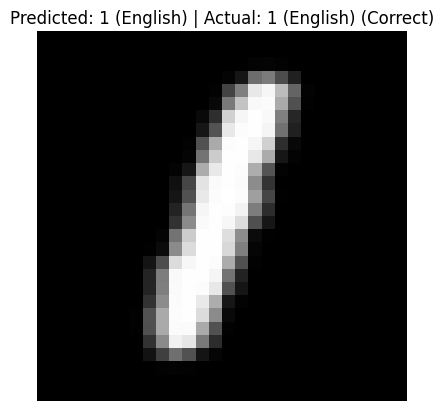

Probabilities for sample 52923:
Class 0 (0 (Arabic)): 0.000000
Class 1 (1 (Arabic)): 0.000000
Class 2 (2 (Arabic)): 0.000000
Class 3 (3 (Arabic)): 0.000000
Class 4 (4 (Arabic)): 0.000000
Class 5 (5 (Arabic)): 0.000000
Class 6 (6 (Arabic)): 0.000000
Class 7 (7 (Arabic)): 0.000000
Class 8 (8 (Arabic)): 0.000000
Class 9 (9 (Arabic)): 0.000000
Class 10 (0 (Bangla)): 0.000000
Class 11 (1 (Bangla)): 0.000000
Class 12 (2 (Bangla)): 0.000000
Class 13 (3 (Bangla)): 0.000000
Class 14 (4 (Bangla)): 0.000000
Class 15 (5 (Bangla)): 0.000000
Class 16 (6 (Bangla)): 0.000000
Class 17 (7 (Bangla)): 0.000000
Class 18 (8 (Bangla)): 0.000000
Class 19 (9 (Bangla)): 0.000000
Class 20 (0 (Devanagari)): 0.000000
Class 21 (1 (Devanagari)): 0.000000
Class 22 (2 (Devanagari)): 0.000000
Class 23 (3 (Devanagari)): 0.000000
Class 24 (4 (Devanagari)): 0.000000
Class 25 (5 (Devanagari)): 0.000000
Class 26 (6 (Devanagari)): 0.000000
Class 27 (7 (Devanagari)): 0.000000
Class 28 (8 (Devanagari)): 0.000000
Class 29 (9 (D

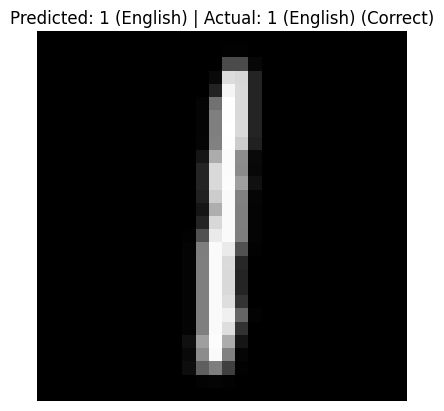

Probabilities for sample 19214:
Class 0 (0 (Arabic)): 0.000000
Class 1 (1 (Arabic)): 0.000000
Class 2 (2 (Arabic)): 0.000000
Class 3 (3 (Arabic)): 0.000000
Class 4 (4 (Arabic)): 0.000000
Class 5 (5 (Arabic)): 0.000000
Class 6 (6 (Arabic)): 0.000000
Class 7 (7 (Arabic)): 0.000000
Class 8 (8 (Arabic)): 0.000000
Class 9 (9 (Arabic)): 0.000000
Class 10 (0 (Bangla)): 0.000000
Class 11 (1 (Bangla)): 0.000000
Class 12 (2 (Bangla)): 0.000000
Class 13 (3 (Bangla)): 0.000000
Class 14 (4 (Bangla)): 0.000000
Class 15 (5 (Bangla)): 0.000000
Class 16 (6 (Bangla)): 0.000000
Class 17 (7 (Bangla)): 0.000000
Class 18 (8 (Bangla)): 1.000000
Class 19 (9 (Bangla)): 0.000000
Class 20 (0 (Devanagari)): 0.000000
Class 21 (1 (Devanagari)): 0.000000
Class 22 (2 (Devanagari)): 0.000000
Class 23 (3 (Devanagari)): 0.000000
Class 24 (4 (Devanagari)): 0.000000
Class 25 (5 (Devanagari)): 0.000000
Class 26 (6 (Devanagari)): 0.000000
Class 27 (7 (Devanagari)): 0.000000
Class 28 (8 (Devanagari)): 0.000000
Class 29 (9 (D

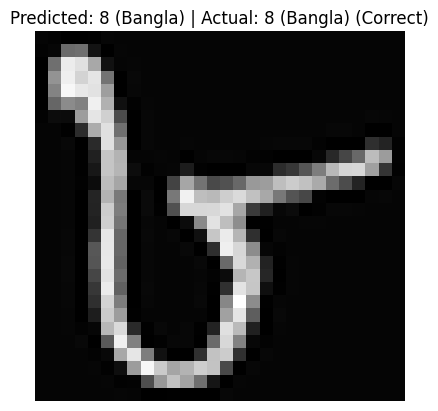

Probabilities for sample 19568:
Class 0 (0 (Arabic)): 0.000000
Class 1 (1 (Arabic)): 0.000000
Class 2 (2 (Arabic)): 0.000000
Class 3 (3 (Arabic)): 0.000000
Class 4 (4 (Arabic)): 0.000000
Class 5 (5 (Arabic)): 0.000000
Class 6 (6 (Arabic)): 0.000000
Class 7 (7 (Arabic)): 0.000000
Class 8 (8 (Arabic)): 0.000000
Class 9 (9 (Arabic)): 0.000000
Class 10 (0 (Bangla)): 0.000000
Class 11 (1 (Bangla)): 0.000015
Class 12 (2 (Bangla)): 0.000000
Class 13 (3 (Bangla)): 0.000000
Class 14 (4 (Bangla)): 0.000000
Class 15 (5 (Bangla)): 0.000000
Class 16 (6 (Bangla)): 0.000000
Class 17 (7 (Bangla)): 0.000000
Class 18 (8 (Bangla)): 0.000000
Class 19 (9 (Bangla)): 0.999985
Class 20 (0 (Devanagari)): 0.000000
Class 21 (1 (Devanagari)): 0.000000
Class 22 (2 (Devanagari)): 0.000000
Class 23 (3 (Devanagari)): 0.000000
Class 24 (4 (Devanagari)): 0.000000
Class 25 (5 (Devanagari)): 0.000000
Class 26 (6 (Devanagari)): 0.000000
Class 27 (7 (Devanagari)): 0.000000
Class 28 (8 (Devanagari)): 0.000000
Class 29 (9 (D

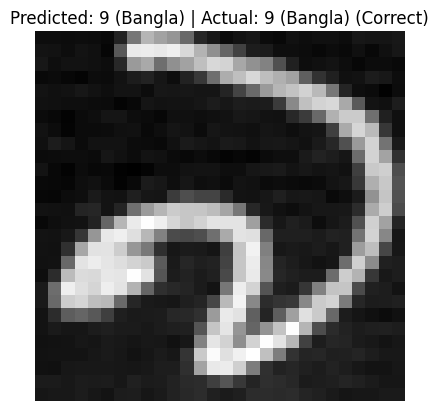

Probabilities for sample 9902:
Class 0 (0 (Arabic)): 0.000000
Class 1 (1 (Arabic)): 0.000000
Class 2 (2 (Arabic)): 0.999992
Class 3 (3 (Arabic)): 0.000000
Class 4 (4 (Arabic)): 0.000008
Class 5 (5 (Arabic)): 0.000000
Class 6 (6 (Arabic)): 0.000000
Class 7 (7 (Arabic)): 0.000000
Class 8 (8 (Arabic)): 0.000000
Class 9 (9 (Arabic)): 0.000000
Class 10 (0 (Bangla)): 0.000000
Class 11 (1 (Bangla)): 0.000000
Class 12 (2 (Bangla)): 0.000000
Class 13 (3 (Bangla)): 0.000000
Class 14 (4 (Bangla)): 0.000000
Class 15 (5 (Bangla)): 0.000000
Class 16 (6 (Bangla)): 0.000000
Class 17 (7 (Bangla)): 0.000000
Class 18 (8 (Bangla)): 0.000000
Class 19 (9 (Bangla)): 0.000000
Class 20 (0 (Devanagari)): 0.000000
Class 21 (1 (Devanagari)): 0.000000
Class 22 (2 (Devanagari)): 0.000000
Class 23 (3 (Devanagari)): 0.000000
Class 24 (4 (Devanagari)): 0.000000
Class 25 (5 (Devanagari)): 0.000000
Class 26 (6 (Devanagari)): 0.000000
Class 27 (7 (Devanagari)): 0.000000
Class 28 (8 (Devanagari)): 0.000000
Class 29 (9 (De

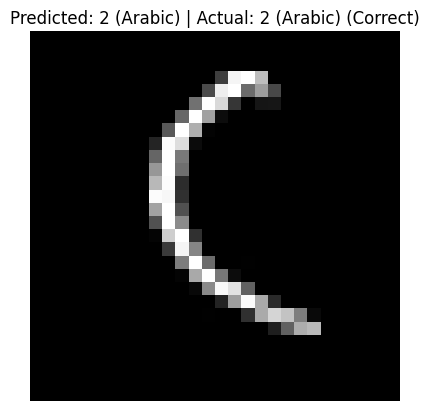

Probabilities for sample 38317:
Class 0 (0 (Arabic)): 0.000000
Class 1 (1 (Arabic)): 0.000000
Class 2 (2 (Arabic)): 0.000000
Class 3 (3 (Arabic)): 0.000000
Class 4 (4 (Arabic)): 0.000000
Class 5 (5 (Arabic)): 0.000000
Class 6 (6 (Arabic)): 0.000000
Class 7 (7 (Arabic)): 0.000000
Class 8 (8 (Arabic)): 0.000000
Class 9 (9 (Arabic)): 0.000000
Class 10 (0 (Bangla)): 0.000000
Class 11 (1 (Bangla)): 0.000000
Class 12 (2 (Bangla)): 0.000000
Class 13 (3 (Bangla)): 0.000000
Class 14 (4 (Bangla)): 0.000000
Class 15 (5 (Bangla)): 0.000000
Class 16 (6 (Bangla)): 0.000000
Class 17 (7 (Bangla)): 0.000000
Class 18 (8 (Bangla)): 0.000000
Class 19 (9 (Bangla)): 0.000000
Class 20 (0 (Devanagari)): 0.000000
Class 21 (1 (Devanagari)): 0.000000
Class 22 (2 (Devanagari)): 0.000000
Class 23 (3 (Devanagari)): 0.000000
Class 24 (4 (Devanagari)): 0.000000
Class 25 (5 (Devanagari)): 0.000000
Class 26 (6 (Devanagari)): 0.000000
Class 27 (7 (Devanagari)): 0.000000
Class 28 (8 (Devanagari)): 0.000000
Class 29 (9 (D

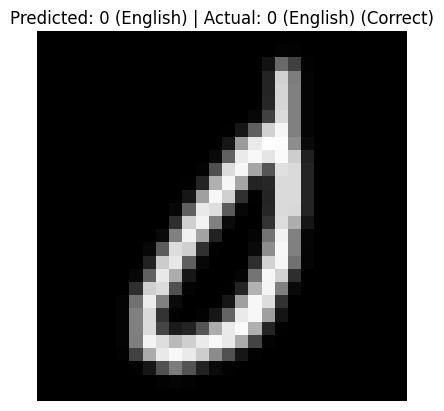

Probabilities for sample 36196:
Class 0 (0 (Arabic)): 0.000000
Class 1 (1 (Arabic)): 0.000000
Class 2 (2 (Arabic)): 0.000000
Class 3 (3 (Arabic)): 0.000000
Class 4 (4 (Arabic)): 0.000000
Class 5 (5 (Arabic)): 0.000000
Class 6 (6 (Arabic)): 0.000000
Class 7 (7 (Arabic)): 0.000000
Class 8 (8 (Arabic)): 0.000000
Class 9 (9 (Arabic)): 0.000000
Class 10 (0 (Bangla)): 0.000000
Class 11 (1 (Bangla)): 0.000000
Class 12 (2 (Bangla)): 0.000000
Class 13 (3 (Bangla)): 0.000000
Class 14 (4 (Bangla)): 0.000000
Class 15 (5 (Bangla)): 0.000000
Class 16 (6 (Bangla)): 0.000000
Class 17 (7 (Bangla)): 0.000000
Class 18 (8 (Bangla)): 0.000000
Class 19 (9 (Bangla)): 0.000000
Class 20 (0 (Devanagari)): 0.000000
Class 21 (1 (Devanagari)): 0.000000
Class 22 (2 (Devanagari)): 0.000000
Class 23 (3 (Devanagari)): 0.000000
Class 24 (4 (Devanagari)): 0.000000
Class 25 (5 (Devanagari)): 0.000000
Class 26 (6 (Devanagari)): 0.000000
Class 27 (7 (Devanagari)): 0.000000
Class 28 (8 (Devanagari)): 0.000000
Class 29 (9 (D

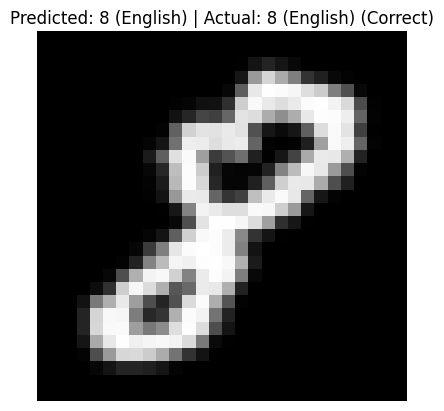

Probabilities for sample 34682:
Class 0 (0 (Arabic)): 0.000000
Class 1 (1 (Arabic)): 0.000000
Class 2 (2 (Arabic)): 0.000000
Class 3 (3 (Arabic)): 0.000000
Class 4 (4 (Arabic)): 0.000000
Class 5 (5 (Arabic)): 0.000000
Class 6 (6 (Arabic)): 0.000000
Class 7 (7 (Arabic)): 0.000000
Class 8 (8 (Arabic)): 0.000000
Class 9 (9 (Arabic)): 0.000000
Class 10 (0 (Bangla)): 0.000000
Class 11 (1 (Bangla)): 0.000000
Class 12 (2 (Bangla)): 0.000000
Class 13 (3 (Bangla)): 0.000000
Class 14 (4 (Bangla)): 0.000000
Class 15 (5 (Bangla)): 0.000000
Class 16 (6 (Bangla)): 0.000000
Class 17 (7 (Bangla)): 0.000000
Class 18 (8 (Bangla)): 0.000000
Class 19 (9 (Bangla)): 0.000000
Class 20 (0 (Devanagari)): 0.000000
Class 21 (1 (Devanagari)): 0.000000
Class 22 (2 (Devanagari)): 0.000000
Class 23 (3 (Devanagari)): 0.000000
Class 24 (4 (Devanagari)): 0.000000
Class 25 (5 (Devanagari)): 0.000000
Class 26 (6 (Devanagari)): 0.000000
Class 27 (7 (Devanagari)): 0.000000
Class 28 (8 (Devanagari)): 0.000000
Class 29 (9 (D

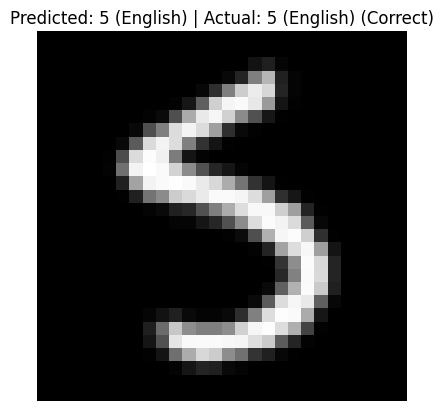

Probabilities for sample 22459:
Class 0 (0 (Arabic)): 0.000000
Class 1 (1 (Arabic)): 0.000000
Class 2 (2 (Arabic)): 0.000000
Class 3 (3 (Arabic)): 0.000000
Class 4 (4 (Arabic)): 0.000000
Class 5 (5 (Arabic)): 0.000000
Class 6 (6 (Arabic)): 0.000000
Class 7 (7 (Arabic)): 0.000000
Class 8 (8 (Arabic)): 0.000000
Class 9 (9 (Arabic)): 0.000000
Class 10 (0 (Bangla)): 0.000000
Class 11 (1 (Bangla)): 0.000000
Class 12 (2 (Bangla)): 0.000000
Class 13 (3 (Bangla)): 0.000000
Class 14 (4 (Bangla)): 0.000000
Class 15 (5 (Bangla)): 0.000000
Class 16 (6 (Bangla)): 0.000000
Class 17 (7 (Bangla)): 0.000000
Class 18 (8 (Bangla)): 0.000000
Class 19 (9 (Bangla)): 0.000000
Class 20 (0 (Devanagari)): 0.000000
Class 21 (1 (Devanagari)): 0.000000
Class 22 (2 (Devanagari)): 0.000000
Class 23 (3 (Devanagari)): 0.000000
Class 24 (4 (Devanagari)): 0.000000
Class 25 (5 (Devanagari)): 0.000000
Class 26 (6 (Devanagari)): 0.000000
Class 27 (7 (Devanagari)): 0.000000
Class 28 (8 (Devanagari)): 0.000000
Class 29 (9 (D

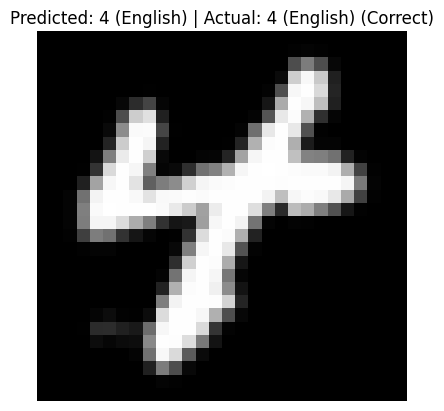

In [16]:
predictions = model.predict(X_test)  # Get predictions for the test set

# Loop through a few random samples
for i in range(10):  # Adjust the range as needed
    num = np.random.randint(0, len(X_test))  # Pick a random sample
    plt.imshow(X_test[num].reshape(28, 28), cmap='gray')  # Display the image
    plt.axis('off')

    predicted_class = np.argmax(predictions[num])  # Predicted class
    actual_class = np.argmax(y_test[num])  # Actual class from labels

    # Check if the prediction is correct
    is_correct = predicted_class == actual_class

    # Display probabilities
    print(f"Probabilities for sample {num}:")
    for cls, prob in enumerate(predictions[num]):
        print(f"Class {cls} ({digit_language_mapping[cls]}): {prob:.6f}")

    # Title with correctness
    plt.title(f"Predicted: {digit_language_mapping[predicted_class]} | "
              f"Actual: {digit_language_mapping[actual_class]} "
              f"{'(Correct)' if is_correct else '(Incorrect)'}")
    plt.show()


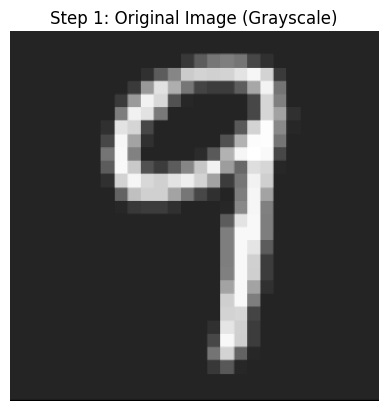

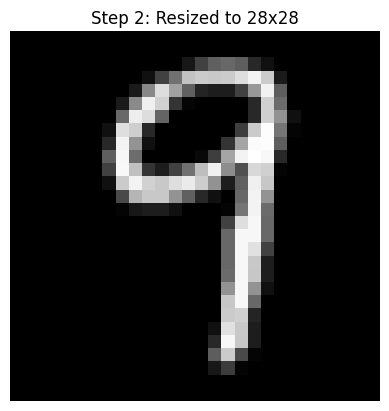

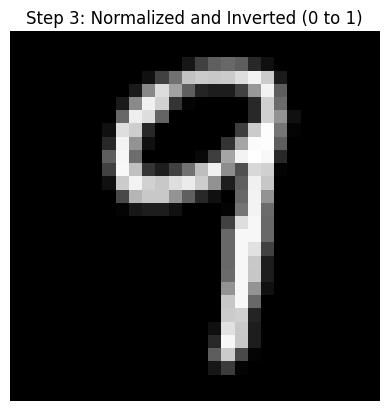

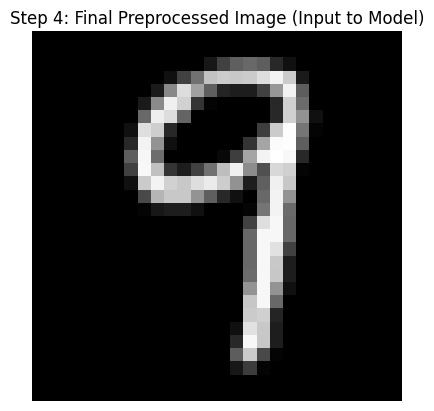

Class probabilities:
Class 0 (0 (Arabic)): 0.000000
Class 1 (1 (Arabic)): 0.000000
Class 2 (2 (Arabic)): 0.000000
Class 3 (3 (Arabic)): 0.000000
Class 4 (4 (Arabic)): 0.000000
Class 5 (5 (Arabic)): 0.000000
Class 6 (6 (Arabic)): 0.000000
Class 7 (7 (Arabic)): 0.000000
Class 8 (8 (Arabic)): 0.000000
Class 9 (9 (Arabic)): 0.000000
Class 10 (0 (Bangla)): 0.000000
Class 11 (1 (Bangla)): 0.000000
Class 12 (2 (Bangla)): 0.000001
Class 13 (3 (Bangla)): 0.000000
Class 14 (4 (Bangla)): 0.000000
Class 15 (5 (Bangla)): 0.000000
Class 16 (6 (Bangla)): 0.000000
Class 17 (7 (Bangla)): 0.947270
Class 18 (8 (Bangla)): 0.000000
Class 19 (9 (Bangla)): 0.000000
Class 20 (0 (Devanagari)): 0.000000
Class 21 (1 (Devanagari)): 0.000000
Class 22 (2 (Devanagari)): 0.000000
Class 23 (3 (Devanagari)): 0.000000
Class 24 (4 (Devanagari)): 0.000000
Class 25 (5 (Devanagari)): 0.000000
Class 26 (6 (Devanagari)): 0.000000
Class 27 (7 (Devanagari)): 0.000000
Class 28 (8 (Devanagari)): 0.000000
Class 29 (9 (Devanagari))

In [21]:
import numpy as np
import cv2

image_path = '/content/drive/MyDrive/Number9.png'

# Step 1: Load the image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
plt.imshow(image, cmap='gray')  # Display original grayscale image
plt.title("Step 1: Original Image (Grayscale)")
plt.axis('off')
plt.show()

# Step 2: Resize the cropped image
resized_image = cv2.resize(image, (28, 28))  # Resize to 28x28 pixels
plt.imshow(resized_image, cmap='gray')  # Display resized image
plt.title("Step 2: Resized to 28x28")
plt.axis('off')
plt.show()

# Step 3: Normalize colors
normalized_image = resized_image.astype('float32') / 255.0  # Normalize pixel values (0 to 1)
plt.imshow(normalized_image, cmap='gray')  # Display inverted image
plt.title("Step 3: Normalized and Inverted (0 to 1)")
plt.axis('off')
plt.show()

# Step 4: Reshape the image for the model
final_image = normalized_image.reshape(1, 28, 28, 1)  # Reshape for model input
plt.imshow(final_image[0, :, :, 0], cmap='gray')  # Display the final preprocessed image
plt.title("Step 4: Final Preprocessed Image (Input to Model)")
plt.axis('off')
plt.show()

# Step 5: Predict the digit
try:
    prediction = model(final_image)

    predicted_class = np.argmax(prediction)


    # Print all probabilities with their corresponding classes
    print("Class probabilities:")
    for i, prob in enumerate(prediction[0]):  # Iterate over all class probabilities
        print(f"Class {i} ({digit_language_mapping[i]}): {prob:.6f}")

    # Use the original and complete digit_language_mapping
    print(f"this digit is {digit_language_mapping[predicted_class]}")

except ValueError as e:
    print("Error during prediction:", e)
